# Recursive Feature Elimination (RFE)

## Read data

In [1]:
import pandas as pd
import psycopg2

# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic4'
hostname = 'localhost'
port_number = 5434
schema_name = 'sepsis_micro'

# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=port_number, password='mysecretpassword')

# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'

dataQuery = """select * from sepsis_micro.data_matrix_qc_1;"""
dataDf = pd.read_sql_query(dataQuery, con)
dataDf

,micro_specimen_id,person_id,seven_day_mortality,fourteen_day_mortality,twentyone_day_mortality,twentyeight_day_mortality,sixty_day_mortality,ninety_day_mortality,onetwenty_day_mortality,Ambulatory Clinic / Center,...,hemoglobin_first,creatinine_first,potassium_last,chloride_last,glucose_last,sodium_last,bicarbonate_last,hemoglobin_last,creatinine_last,time_to_antibiotic
0,2940,-470494077,0,0,0,1,1,1,1,0,...,-0.586379,2.441041,-0.053360,-0.804726,0.726778,-0.800329,0.048541,-0.857543,-0.077536,0.018778
1,3236,-762840899,0,1,1,1,1,1,1,0,...,-0.942367,-0.066982,1.677597,-1.840315,0.615396,-1.745000,0.621905,-1.037712,0.988716,0.018778
2,3720,-1481508426,0,0,0,0,0,0,0,0,...,-0.535524,-0.345652,-1.438125,-1.692373,1.376502,-0.989263,1.004149,-0.377094,-0.290787,0.022081
3,5214,2090709572,0,0,0,0,0,0,0,0,...,-0.789801,-0.554654,0.292832,-0.508844,-0.164272,-1.745000,-1.098189,-0.677375,-0.504037,-1.107961
4,10611,-961491032,0,0,0,0,0,0,0,0,...,1.091850,-0.763656,-0.399551,1.414391,0.763905,0.333277,-0.333703,0.043300,-0.859455,0.034054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7097,9986222,-1199717531,0,0,0,0,0,0,0,0,...,1.447838,-0.554654,0.465927,-0.065021,-0.498416,0.900080,2.533121,-0.377094,-0.575121,0.017126
7098,9989349,-1246337626,0,0,0,0,0,0,0,0,...,1.244416,1.953370,-0.399551,-1.248550,1.357938,-1.745000,-0.715946,0.463693,1.841718,0.031577
7099,9989996,-1704051650,1,1,1,1,1,1,1,0,...,-1.247500,-0.693988,0.119736,0.082921,-0.758306,-1.178197,-0.907067,-1.337993,-0.646204,0.018778
7100,9996881,768076701,0,0,1,1,1,1,1,0,...,-0.586379,-0.833323,-0.572647,-0.656785,-0.609797,0.144343,2.150878,-0.437150,-0.788371,0.031990


## Extract data

In [2]:
X = dataDf.drop(['micro_specimen_id', 'person_id', 'seven_day_mortality', 'fourteen_day_mortality', 'twentyone_day_mortality', 'twentyeight_day_mortality', 'sixty_day_mortality', 'ninety_day_mortality', 'onetwenty_day_mortality'], axis = 1)
y_seven_day = dataDf['seven_day_mortality']
y_fourteen_day = dataDf['fourteen_day_mortality']
y_twentyone_day = dataDf['twentyone_day_mortality']
y_twentyeight_day = dataDf['twentyeight_day_mortality']
y_sixty_day = dataDf['sixty_day_mortality']
y_ninety_day = dataDf['ninety_day_mortality']
y_onetwenty_day = dataDf['onetwenty_day_mortality']

## Plot Confusion Matrix

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10), title='Confusion Matrix for the classifier'):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    #plt.savefig(filename)
    plt.title(title)
    plt.show()

## Seven day mortality prediction

### RFE

In [4]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

# define RFE
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10)
# fit RFE
rfe.fit(X, y_seven_day)

RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10)

In [5]:
# summarize all features
data = []
columns = X.columns
for i in range(X.shape[1]):
    data.append([columns[i], rfe.support_[i], rfe.ranking_[i]])
	# print('Column: %s, Selected %s, Rank: %.3f' % (columns[i], rfe.support_[i], rfe.ranking_[i]))
feDf = pd.DataFrame(data, columns=['Column', 'Selected', 'Rank'])
feDf

,Column,Selected,Rank
0,Ambulatory Clinic / Center,False,150
1,Ambulatory Surgical Center,False,149
2,Emergency Room - Hospital,False,148
3,Emergency Room and Inpatient Visit,False,146
4,Inpatient Visit,False,144
...,...,...,...
154,sodium_last,False,106
155,bicarbonate_last,True,1
156,hemoglobin_last,False,28
157,creatinine_last,False,70


In [6]:
feDf[feDf.Selected]

,Column,Selected,Rank
25,visit_duration_hrs,True,1
56,temp_avg,True,1
102,heartrate_last,True,1
109,meanbp_last,True,1
112,meanbp_ni_last,True,1
113,gcs_motor_last,True,1
125,glucose_min,True,1
143,creatinine_sd,True,1
151,potassium_last,True,1
155,bicarbonate_last,True,1


### RFECV

In [7]:
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

min_features_to_select = 1  # Minimum number of features to consider

rfecv = RFECV(
    estimator=DecisionTreeClassifier(),
    step=1,
    cv=StratifiedKFold(5),
    scoring = "accuracy",
    min_features_to_select = min_features_to_select,
    n_jobs = -1
)

rfecv.fit(X, y_seven_day)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=DecisionTreeClassifier(), n_jobs=-1, scoring='accuracy')

In [8]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 93


/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


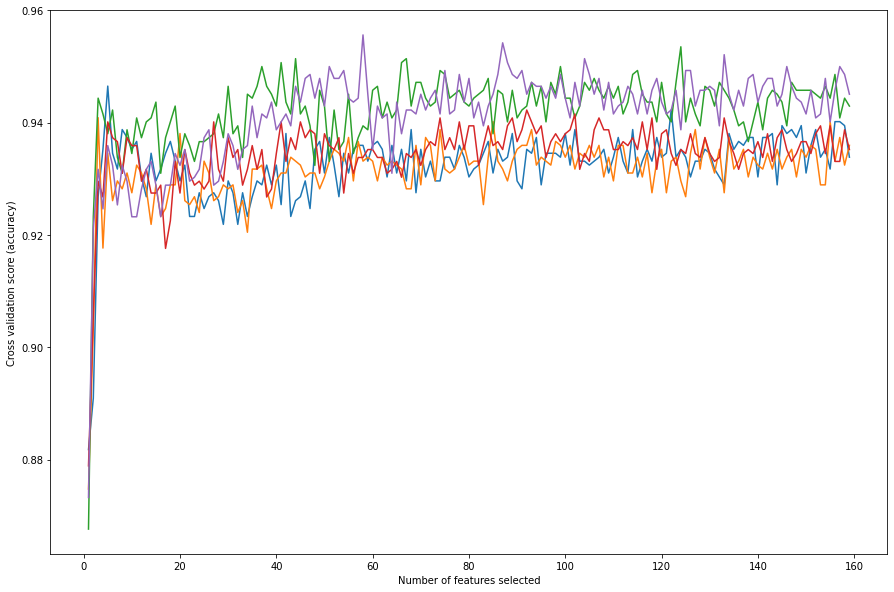

In [9]:
from matplotlib import pyplot as plt

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(15, 10))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


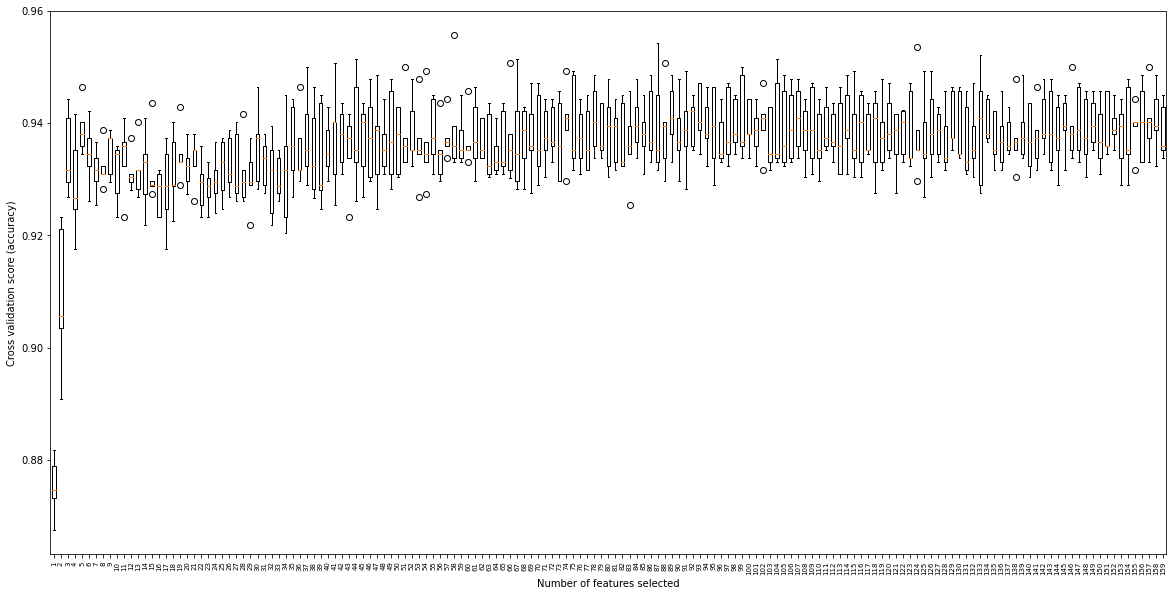

In [10]:
from matplotlib import pyplot as plt

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(20, 10))
plt.xticks(rotation=90, fontsize=7)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.boxplot(
    # range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_.transpose(),
)
plt.show()

### XGBoost

####  Select minimal set of features

In [11]:
X_min = X[feDf[feDf.Selected].Column]

#### Test/Train split

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_seven_day_train, y_seven_day_test = train_test_split(X_min, y_seven_day, test_size=0.2, random_state=42)

In [13]:
X_train.shape, X_test.shape

((5681, 10), (1421, 10))

In [14]:
y_seven_day_train.shape, y_seven_day_test.shape

((5681,), (1421,))

#### Fit and Predict

In [15]:
from xgboost import XGBClassifier
from matplotlib import pyplot as plt

xgb_seven_day = XGBClassifier()
xgb_seven_day.fit(X_train, y_seven_day_train)
y_seven_day_pred = xgb_seven_day.predict(X_test)
y_seven_day_prob = xgb_seven_day.predict_proba(X_test)

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:11:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


#### Performance metrics

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score

print('Seven day mortality accuracy: ', str(accuracy_score(y_seven_day_pred, y_seven_day_test)))
print('Seven day mortality F1: ', str(f1_score(y_seven_day_pred, y_seven_day_test)))
print('Seven day mortality MCC: ', str(matthews_corrcoef(y_seven_day_pred, y_seven_day_test)))
print('Seven day mortality AUROC: ', str(roc_auc_score(y_seven_day_pred, y_seven_day_test)))

Seven day mortality accuracy:  0.9683321604503871
Seven day mortality F1:  0.89749430523918
Seven day mortality MCC:  0.8805187515823057
Seven day mortality AUROC:  0.9595428530661423


#### Confusion matrix

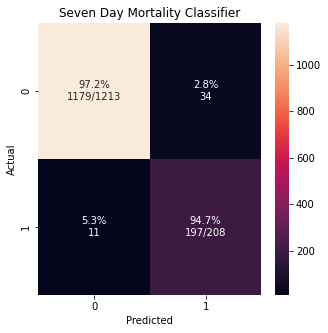

In [17]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

labels = [0, 1]

cm_analysis(y_seven_day_pred, y_seven_day_test, labels, ymap=None, figsize=(5, 5), title='Seven Day Mortality Classifier')

#### AUROC

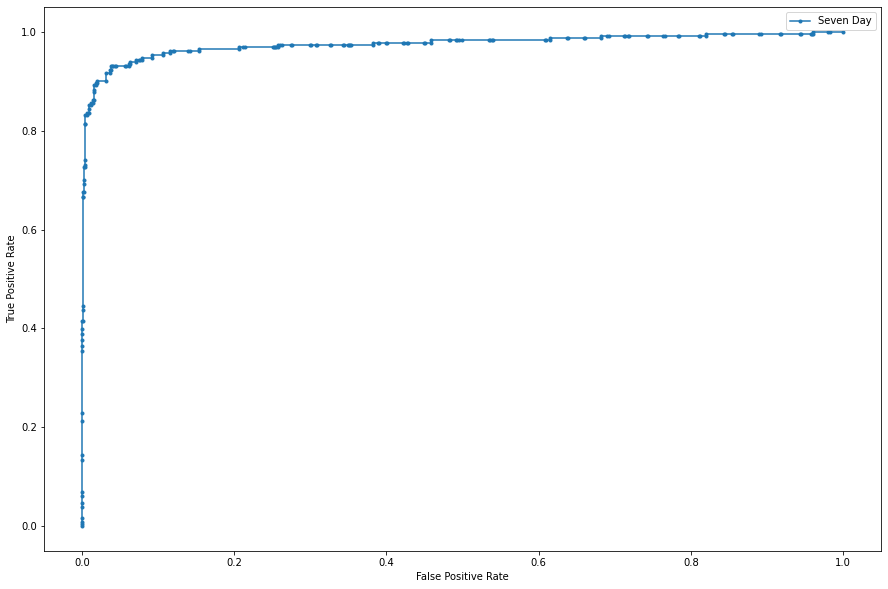

In [18]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(15,10))

for (test, prob, label) in [
        (y_seven_day_test, y_seven_day_prob, 'Seven Day')
    ]:
    fpr, tpr, _ = roc_curve(test, [p2 for p1, p2 in prob])
    plt.plot(fpr, tpr, marker='.', label=label)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## Fourteen day mortality prediction

### RFE

In [19]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

# define RFE
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10)
# fit RFE
rfe.fit(X, y_fourteen_day)

RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10)

In [20]:
# summarize all features
data = []
columns = X.columns
for i in range(X.shape[1]):
    data.append([columns[i], rfe.support_[i], rfe.ranking_[i]])
	# print('Column: %s, Selected %s, Rank: %.3f' % (columns[i], rfe.support_[i], rfe.ranking_[i]))
feDf = pd.DataFrame(data, columns=['Column', 'Selected', 'Rank'])
feDf

,Column,Selected,Rank
0,Ambulatory Clinic / Center,False,150
1,Ambulatory Surgical Center,False,149
2,Emergency Room - Hospital,False,148
3,Emergency Room and Inpatient Visit,False,145
4,Inpatient Visit,False,144
...,...,...,...
154,sodium_last,False,62
155,bicarbonate_last,True,1
156,hemoglobin_last,False,16
157,creatinine_last,True,1


In [21]:
feDf[feDf.Selected]

,Column,Selected,Rank
25,visit_duration_hrs,True,1
26,temp_max,True,1
48,diabp_min,True,1
58,breath_rate_vent_avg,True,1
110,sysbp_ni_last,True,1
113,gcs_motor_last,True,1
118,glucose_max,True,1
149,hemoglobin_first,True,1
155,bicarbonate_last,True,1
157,creatinine_last,True,1


### RFECV

In [22]:
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

min_features_to_select = 1  # Minimum number of features to consider

rfecv = RFECV(
    estimator=DecisionTreeClassifier(),
    step=1,
    cv=StratifiedKFold(5),
    scoring = "accuracy",
    min_features_to_select = min_features_to_select,
    n_jobs=-1,
)

rfecv.fit(X, y_fourteen_day)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=DecisionTreeClassifier(), n_jobs=-1, scoring='accuracy')

In [23]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 104


/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


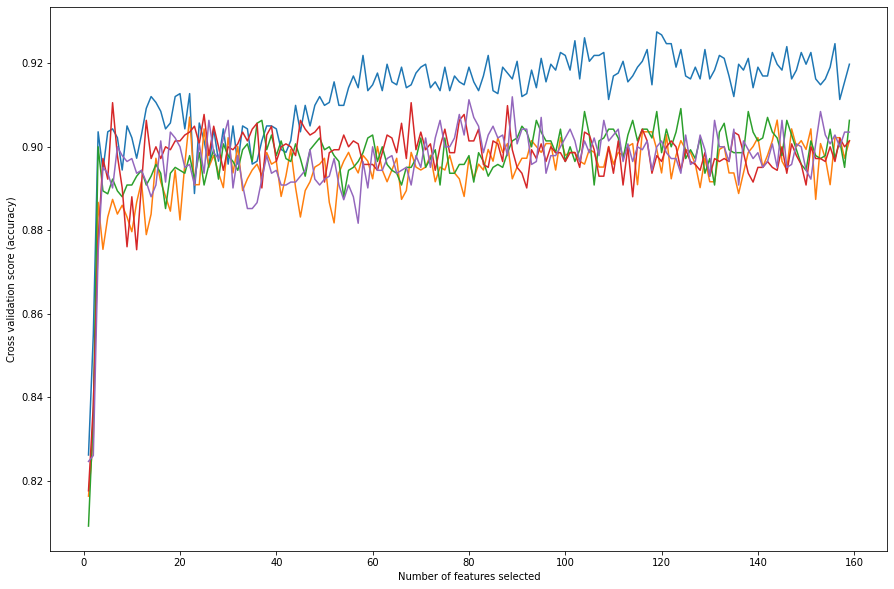

In [24]:
from matplotlib import pyplot as plt

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(15, 10))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


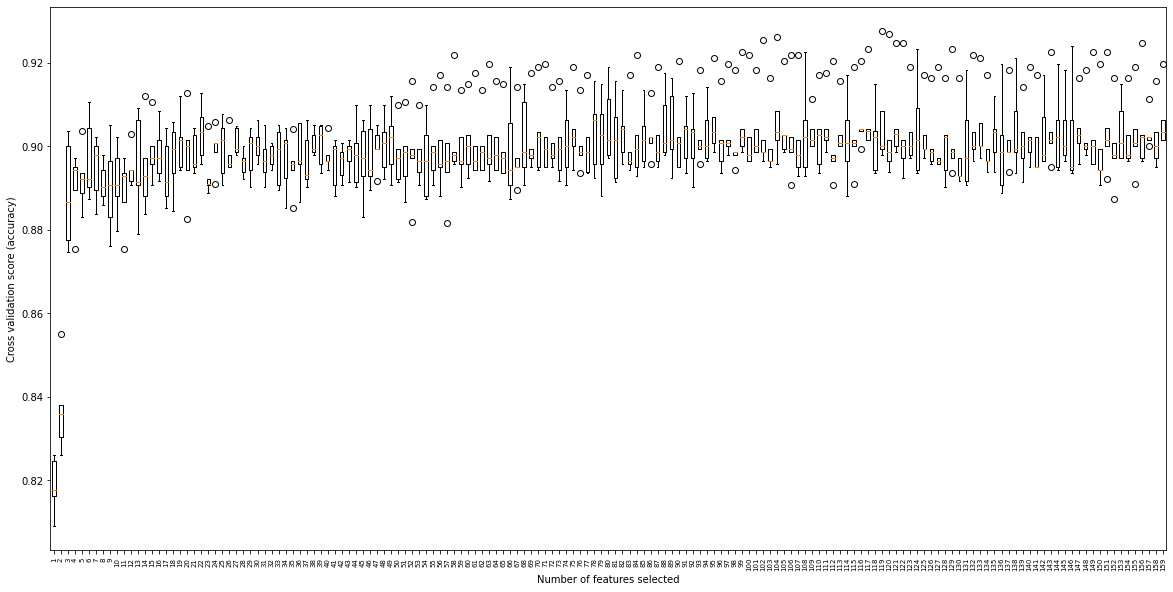

In [25]:
from matplotlib import pyplot as plt

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(20, 10))
plt.xticks(rotation=90, fontsize=7)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.boxplot(
    # range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_.transpose(),
)
plt.show()

### XGBoost

####  Select minimal set of features

In [26]:
X_min = X[feDf[feDf.Selected].Column]

#### Test/Train split

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_fourteen_day_train, y_fourteen_day_test = train_test_split(X_min, y_fourteen_day, test_size=0.2, random_state=42)

In [28]:
X_train.shape, X_test.shape

((5681, 10), (1421, 10))

In [29]:
y_fourteen_day_train.shape, y_fourteen_day_test.shape

((5681,), (1421,))

#### Fit and Predict

In [30]:
from xgboost import XGBClassifier
from matplotlib import pyplot as plt

xgb_fourteen_day = XGBClassifier()
xgb_fourteen_day.fit(X_train, y_fourteen_day_train)
y_fourteen_day_pred = xgb_fourteen_day.predict(X_test)
y_fourteen_day_prob = xgb_fourteen_day.predict_proba(X_test)

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:16:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


#### Performance metrics

In [31]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score

print('Fourteen day mortality accuracy: ', str(accuracy_score(y_fourteen_day_pred, y_fourteen_day_test)))
print('Fourteen day mortality F1: ', str(f1_score(y_fourteen_day_pred, y_fourteen_day_test)))
print('Fourteen day mortality MCC: ', str(matthews_corrcoef(y_fourteen_day_pred, y_fourteen_day_test)))
print('Fourteen day mortality AUROC: ', str(roc_auc_score(y_fourteen_day_pred, y_fourteen_day_test)))

Fourteen day mortality accuracy:  0.9451090781140042
Fourteen day mortality F1:  0.8686868686868686
Fourteen day mortality MCC:  0.8386480222712626
Fourteen day mortality AUROC:  0.9450884481372285


#### Confusion matrix

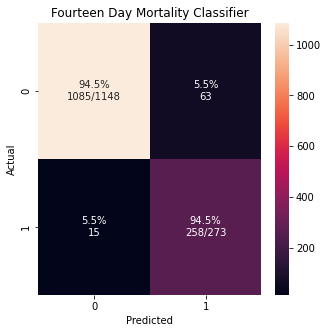

In [32]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

labels = [0, 1]

cm_analysis(y_fourteen_day_pred, y_fourteen_day_test, labels, ymap=None, figsize=(5, 5), title='Fourteen Day Mortality Classifier')

#### AUROC

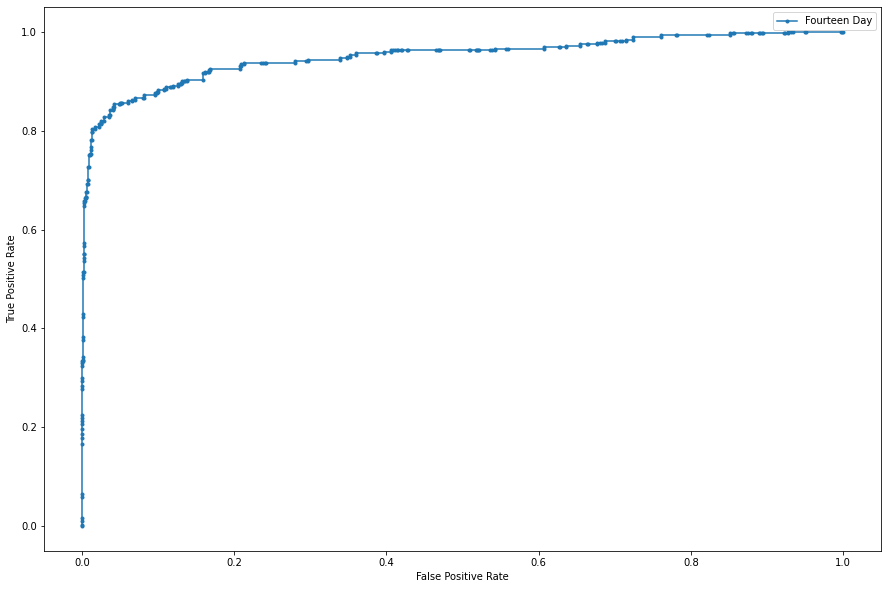

In [33]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(15,10))

for (test, prob, label) in [
        (y_fourteen_day_test, y_fourteen_day_prob, 'Fourteen Day')
    ]:
    fpr, tpr, _ = roc_curve(test, [p2 for p1, p2 in prob])
    plt.plot(fpr, tpr, marker='.', label=label)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## Twentyone day mortality prediction

### RFE

In [34]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

# define RFE
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10)
# fit RFE
rfe.fit(X, y_twentyone_day)

RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10)

In [35]:
# summarize all features
data = []
columns = X.columns
for i in range(X.shape[1]):
    data.append([columns[i], rfe.support_[i], rfe.ranking_[i]])
	# print('Column: %s, Selected %s, Rank: %.3f' % (columns[i], rfe.support_[i], rfe.ranking_[i]))
feDf = pd.DataFrame(data, columns=['Column', 'Selected', 'Rank'])
feDf

,Column,Selected,Rank
0,Ambulatory Clinic / Center,False,150
1,Ambulatory Surgical Center,False,148
2,Emergency Room - Hospital,False,146
3,Emergency Room and Inpatient Visit,False,46
4,Inpatient Visit,False,128
...,...,...,...
154,sodium_last,False,106
155,bicarbonate_last,True,1
156,hemoglobin_last,False,74
157,creatinine_last,True,1


In [36]:
feDf[feDf.Selected]

,Column,Selected,Rank
25,visit_duration_hrs,True,1
56,temp_avg,True,1
76,oxygen_sd,True,1
102,heartrate_last,True,1
110,sysbp_ni_last,True,1
113,gcs_motor_last,True,1
143,creatinine_sd,True,1
146,glucose_first,True,1
155,bicarbonate_last,True,1
157,creatinine_last,True,1


### RFECV

In [37]:
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

min_features_to_select = 1  # Minimum number of features to consider

rfecv = RFECV(
    estimator=DecisionTreeClassifier(),
    step=1,
    cv=StratifiedKFold(5),
    scoring = "accuracy",
    min_features_to_select = min_features_to_select,
    n_jobs = -1,
)

rfecv.fit(X, y_twentyone_day)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=DecisionTreeClassifier(), n_jobs=-1, scoring='accuracy')

In [38]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 33


/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


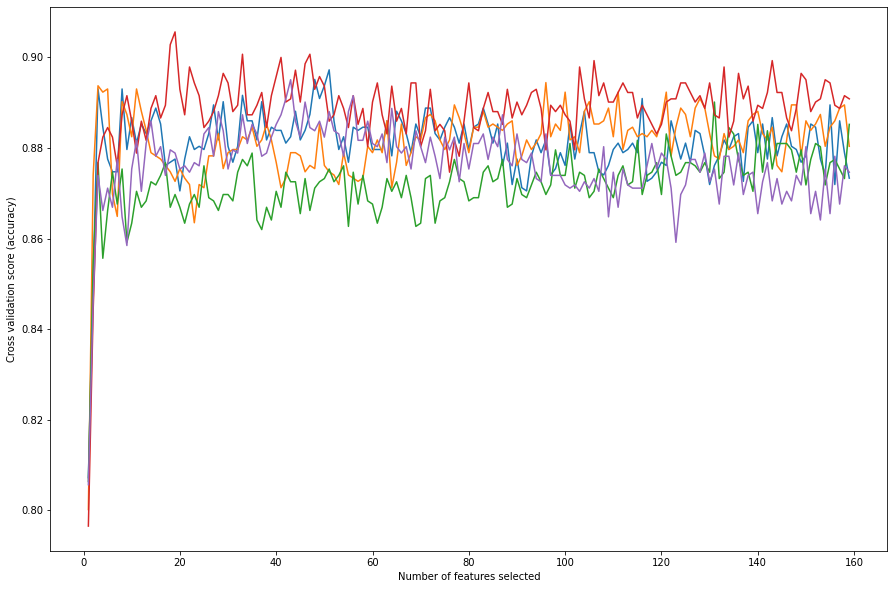

In [39]:
from matplotlib import pyplot as plt

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(15, 10))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


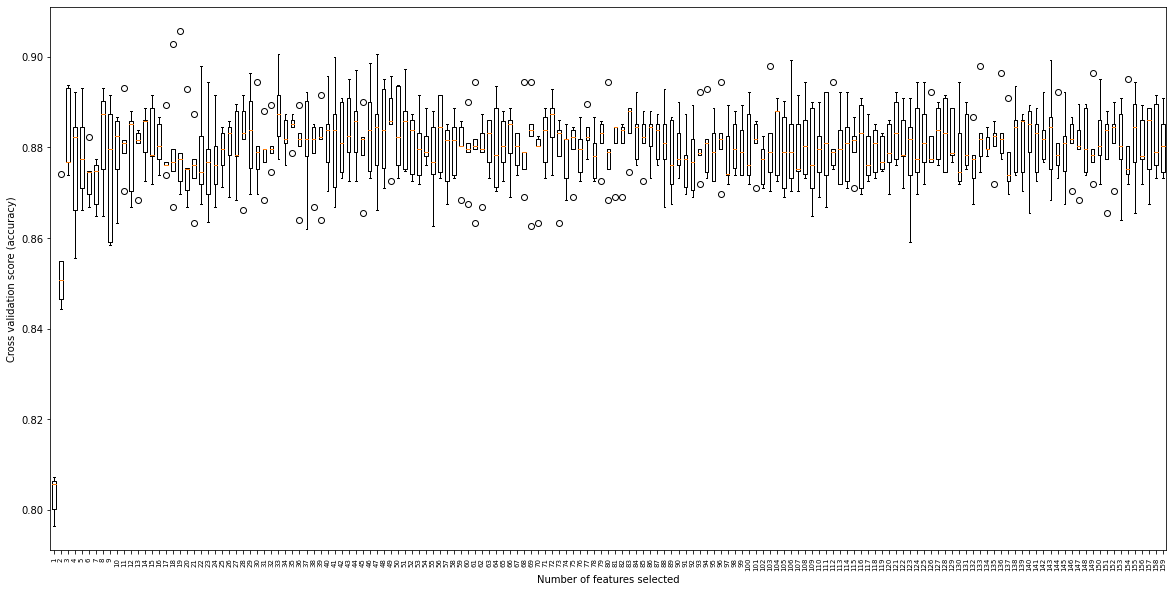

In [40]:
from matplotlib import pyplot as plt

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(20, 10))
plt.xticks(rotation=90, fontsize=7)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.boxplot(
    # range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_.transpose(),
)
plt.show()

### XGBoost

####  Select minimal set of features

In [41]:
X_min = X[feDf[feDf.Selected].Column]

#### Test/Train split

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_twentyone_day_train, y_twentyone_day_test = train_test_split(X_min, y_twentyone_day, test_size=0.2, random_state=42)

In [43]:
X_train.shape, X_test.shape

((5681, 10), (1421, 10))

In [44]:
y_twentyone_day_train.shape, y_twentyone_day_test.shape

((5681,), (1421,))

#### Fit and Predict

In [45]:
from xgboost import XGBClassifier
from matplotlib import pyplot as plt

xgb_twentyone_day = XGBClassifier()
xgb_twentyone_day.fit(X_train, y_twentyone_day_train)
y_twentyone_day_pred = xgb_twentyone_day.predict(X_test)
y_twentyone_day_prob = xgb_twentyone_day.predict_proba(X_test)

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:22:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


#### Performance metrics

In [46]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score

print('Twentyone day mortality accuracy: ', str(accuracy_score(y_twentyone_day_pred, y_twentyone_day_test)))
print('Twentyone day mortality F1: ', str(f1_score(y_twentyone_day_pred, y_twentyone_day_test)))
print('Twentyone day mortality MCC: ', str(matthews_corrcoef(y_twentyone_day_pred, y_twentyone_day_test)))
print('Twentyone day mortality AUROC: ', str(roc_auc_score(y_twentyone_day_pred, y_twentyone_day_test)))

Twentyone day mortality accuracy:  0.9232934553131598
Twentyone day mortality F1:  0.8360902255639097
Twentyone day mortality MCC:  0.7903619637538132
Twentyone day mortality AUROC:  0.9168620869127889


#### Confusion matrix

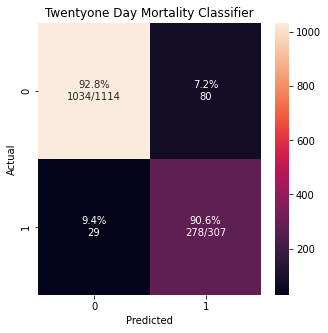

In [47]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

labels = [0, 1]

cm_analysis(y_twentyone_day_pred, y_twentyone_day_test, labels, ymap=None, figsize=(5, 5), title='Twentyone Day Mortality Classifier')

#### AUROC

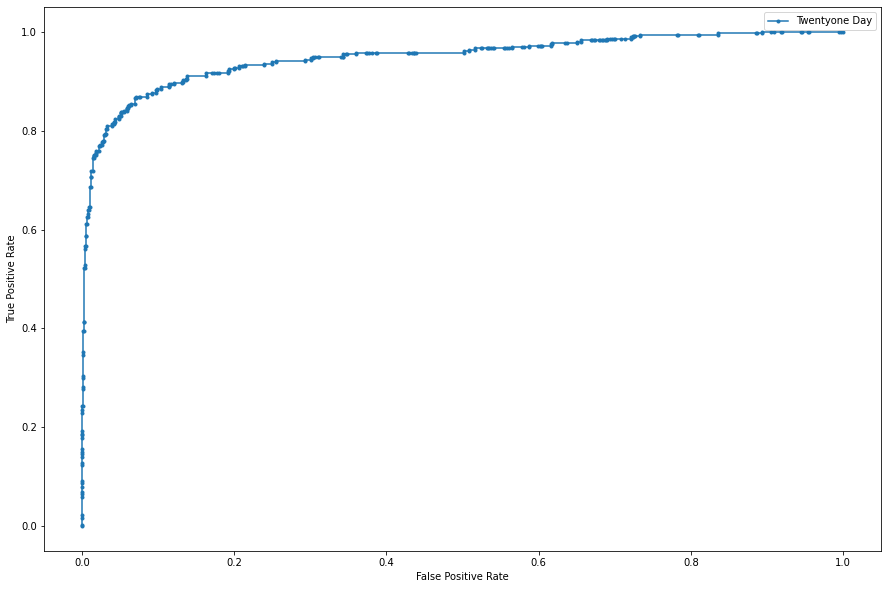

In [48]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(15,10))

for (test, prob, label) in [
        (y_twentyone_day_test, y_twentyone_day_prob, 'Twentyone Day')
    ]:
    fpr, tpr, _ = roc_curve(test, [p2 for p1, p2 in prob])
    plt.plot(fpr, tpr, marker='.', label=label)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## Twentyeight day mortality prediction

### RFE

In [49]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

# define RFE
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10)
# fit RFE
rfe.fit(X, y_twentyeight_day)

RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10)

In [50]:
# summarize all features
data = []
columns = X.columns
for i in range(X.shape[1]):
    data.append([columns[i], rfe.support_[i], rfe.ranking_[i]])
	# print('Column: %s, Selected %s, Rank: %.3f' % (columns[i], rfe.support_[i], rfe.ranking_[i]))
feDf = pd.DataFrame(data, columns=['Column', 'Selected', 'Rank'])
feDf

,Column,Selected,Rank
0,Ambulatory Clinic / Center,False,150
1,Ambulatory Surgical Center,False,149
2,Emergency Room - Hospital,False,148
3,Emergency Room and Inpatient Visit,False,147
4,Inpatient Visit,False,146
...,...,...,...
154,sodium_last,False,64
155,bicarbonate_last,True,1
156,hemoglobin_last,False,84
157,creatinine_last,False,91


In [51]:
feDf[feDf.Selected]

,Column,Selected,Rank
25,visit_duration_hrs,True,1
48,diabp_min,True,1
56,temp_avg,True,1
65,sysbp_ni_avg,True,1
102,heartrate_last,True,1
113,gcs_motor_last,True,1
133,sodium_avg,True,1
136,creatinine_avg,True,1
143,creatinine_sd,True,1
155,bicarbonate_last,True,1


### RFECV

In [52]:
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

min_features_to_select = 1  # Minimum number of features to consider

rfecv = RFECV(
    estimator=DecisionTreeClassifier(),
    step=1,
    cv=StratifiedKFold(5),
    scoring = "accuracy",
    min_features_to_select = min_features_to_select,
    n_jobs = -1,
)

rfecv.fit(X, y_twentyeight_day)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=DecisionTreeClassifier(), n_jobs=-1, scoring='accuracy')

In [53]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 32


/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


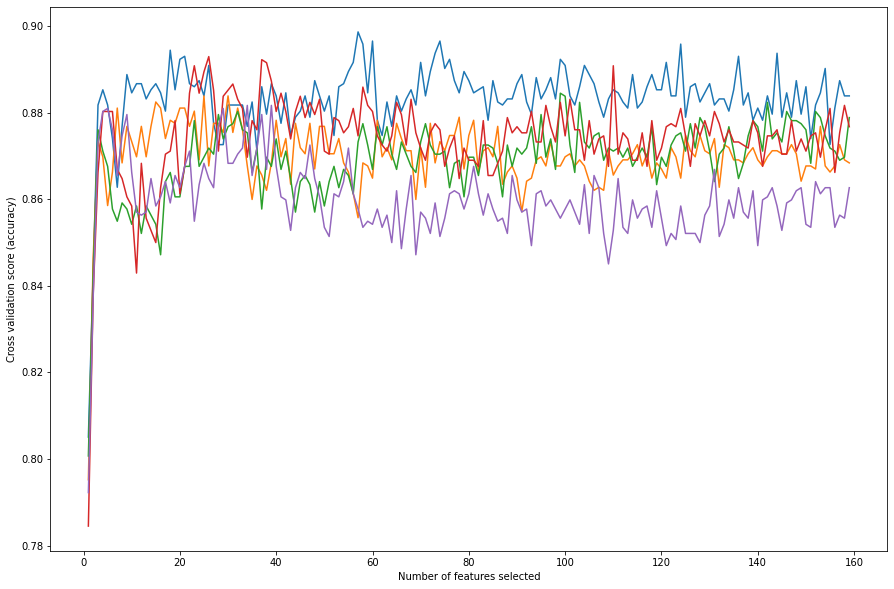

In [54]:
from matplotlib import pyplot as plt

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(15, 10))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


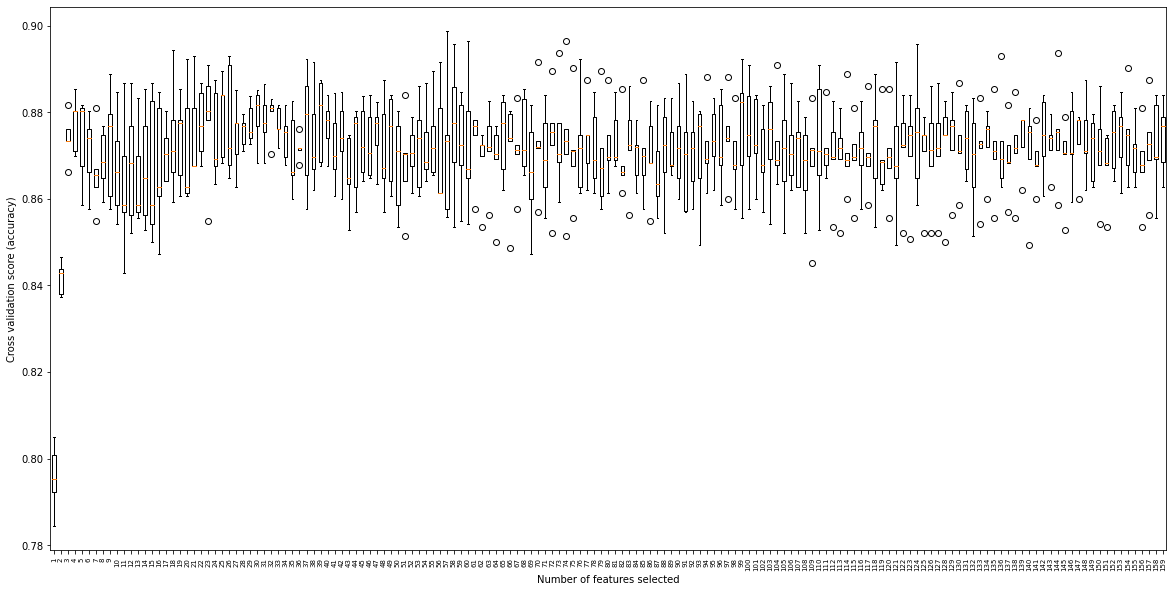

In [55]:
from matplotlib import pyplot as plt

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(20, 10))
plt.xticks(rotation=90, fontsize=7)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.boxplot(
    # range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_.transpose(),
)
plt.show()

### XGBoost

####  Select minimal set of features

In [56]:
X_min = X[feDf[feDf.Selected].Column]

#### Test/Train split

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_twentyeight_day_train, y_twentyeight_day_test = train_test_split(X_min, y_twentyeight_day, test_size=0.2, random_state=42)

In [58]:
X_train.shape, X_test.shape

((5681, 10), (1421, 10))

In [59]:
y_twentyeight_day_train.shape, y_twentyeight_day_test.shape

((5681,), (1421,))

#### Fit and Predict

In [60]:
from xgboost import XGBClassifier
from matplotlib import pyplot as plt

xgb_twentyeight_day = XGBClassifier()
xgb_twentyeight_day.fit(X_train, y_twentyeight_day_train)
y_twentyeight_day_pred = xgb_twentyeight_day.predict(X_test)
y_twentyeight_day_prob = xgb_twentyeight_day.predict_proba(X_test)

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:28:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


#### Performance metrics

In [61]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score

print('Twentyeight day mortality accuracy: ', str(accuracy_score(y_twentyeight_day_pred, y_twentyeight_day_test)))
print('Twentyeight day mortality F1: ', str(f1_score(y_twentyeight_day_pred, y_twentyeight_day_test)))
print('Twentyeight day mortality MCC: ', str(matthews_corrcoef(y_twentyeight_day_pred, y_twentyeight_day_test)))
print('Twentyeight day mortality AUROC: ', str(roc_auc_score(y_twentyeight_day_pred, y_twentyeight_day_test)))

Twentyeight day mortality accuracy:  0.912033779028853
Twentyeight day mortality F1:  0.8285322359396434
Twentyeight day mortality MCC:  0.7726068488574659
Twentyeight day mortality AUROC:  0.9030004344520475


#### Confusion matrix

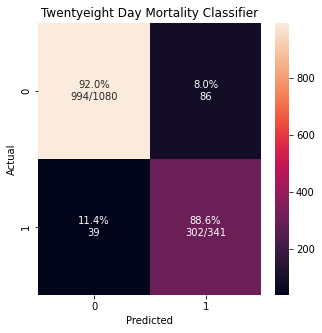

In [62]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

labels = [0, 1]

cm_analysis(y_twentyeight_day_pred, y_twentyeight_day_test, labels, ymap=None, figsize=(5, 5), title='Twentyeight Day Mortality Classifier')

#### AUROC

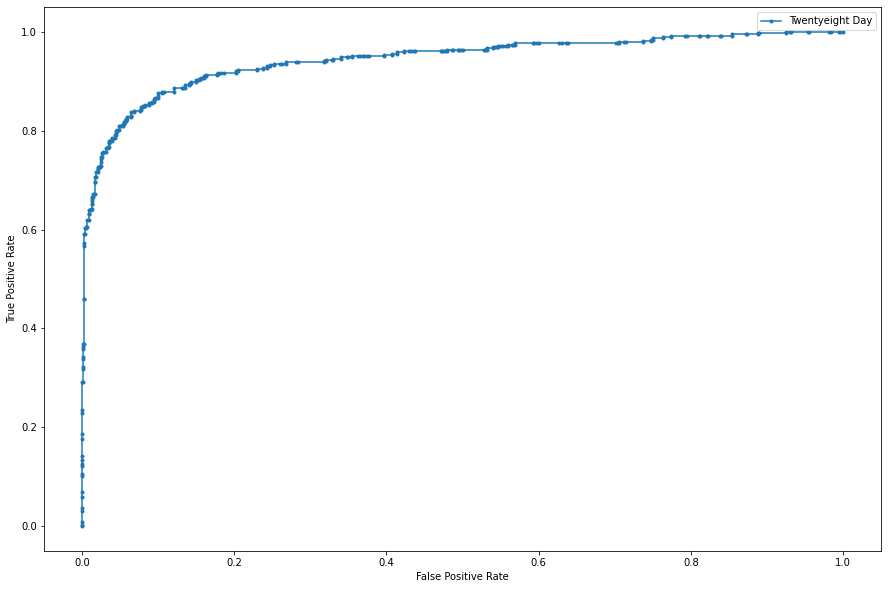

In [63]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(15,10))

for (test, prob, label) in [
        (y_twentyeight_day_test, y_twentyeight_day_prob, 'Twentyeight Day')
    ]:
    fpr, tpr, _ = roc_curve(test, [p2 for p1, p2 in prob])
    plt.plot(fpr, tpr, marker='.', label=label)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## Sixty day mortality prediction

### RFE

In [64]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

# define RFE
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10)
# fit RFE
rfe.fit(X, y_sixty_day)

RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10)

In [65]:
# summarize all features
data = []
columns = X.columns
for i in range(X.shape[1]):
    data.append([columns[i], rfe.support_[i], rfe.ranking_[i]])
	# print('Column: %s, Selected %s, Rank: %.3f' % (columns[i], rfe.support_[i], rfe.ranking_[i]))
feDf = pd.DataFrame(data, columns=['Column', 'Selected', 'Rank'])
feDf

,Column,Selected,Rank
0,Ambulatory Clinic / Center,False,150
1,Ambulatory Surgical Center,False,149
2,Emergency Room - Hospital,False,148
3,Emergency Room and Inpatient Visit,False,147
4,Inpatient Visit,False,143
...,...,...,...
154,sodium_last,False,55
155,bicarbonate_last,True,1
156,hemoglobin_last,False,31
157,creatinine_last,False,124


In [66]:
feDf[feDf.Selected]

,Column,Selected,Rank
25,visit_duration_hrs,True,1
42,heartrate_min,True,1
48,diabp_min,True,1
56,temp_avg,True,1
65,sysbp_ni_avg,True,1
113,gcs_motor_last,True,1
118,glucose_max,True,1
125,glucose_min,True,1
135,hemoglobin_avg,True,1
155,bicarbonate_last,True,1


### RFECV

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

min_features_to_select = 1  # Minimum number of features to consider

rfecv = RFECV(
    estimator=DecisionTreeClassifier(),
    step=1,
    cv=StratifiedKFold(5),
    scoring = "accuracy",
    min_features_to_select = min_features_to_select,
    n_jobs = -1,
)

rfecv.fit(X, y_sixty_day)

In [ ]:
print("Optimal number of features : %d" % rfecv.n_features_)

In [ ]:
from matplotlib import pyplot as plt

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(15, 10))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

In [ ]:
from matplotlib import pyplot as plt

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(20, 10))
plt.xticks(rotation=90, fontsize=7)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.boxplot(
    # range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_.transpose(),
)
plt.show()

### XGBoost

####  Select minimal set of features

In [ ]:
X_min = X[feDf[feDf.Selected].Column]

#### Test/Train split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_sixty_day_train, y_sixty_day_test = train_test_split(X_min, y_sixty_day, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape

In [ ]:
y_sixty_day_train.shape, y_sixty_day_test.shape

#### Fit and Predict

In [ ]:
from xgboost import XGBClassifier
from matplotlib import pyplot as plt

xgb_sixty_day = XGBClassifier()
xgb_sixty_day.fit(X_train, y_sixty_day_train)
y_sixty_day_pred = xgb_sixty_day.predict(X_test)
y_sixty_day_prob = xgb_sixty_day.predict_proba(X_test)

#### Performance metrics

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score

print('Sixty day mortality accuracy: ', str(accuracy_score(y_sixty_day_pred, y_sixty_day_test)))
print('Sixty day mortality F1: ', str(f1_score(y_sixty_day_pred, y_sixty_day_test)))
print('Sixty day mortality MCC: ', str(matthews_corrcoef(y_sixty_day_pred, y_sixty_day_test)))
print('Sixty day mortality AUROC: ', str(roc_auc_score(y_sixty_day_pred, y_sixty_day_test)))

#### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

labels = [0, 1]

cm_analysis(y_sixty_day_pred, y_sixty_day_test, labels, ymap=None, figsize=(5, 5), title='Sixty Day Mortality Classifier')

#### AUROC

In [ ]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(15,10))

for (test, prob, label) in [
        (y_sixty_day_test, y_sixty_day_prob, 'Sixty Day')
    ]:
    fpr, tpr, _ = roc_curve(test, [p2 for p1, p2 in prob])
    plt.plot(fpr, tpr, marker='.', label=label)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## Ninety day mortality prediction

### RFE

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

# define RFE
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10)
# fit RFE
rfe.fit(X, y_ninety_day)

In [ ]:
# summarize all features
data = []
columns = X.columns
for i in range(X.shape[1]):
    data.append([columns[i], rfe.support_[i], rfe.ranking_[i]])
	# print('Column: %s, Selected %s, Rank: %.3f' % (columns[i], rfe.support_[i], rfe.ranking_[i]))
feDf = pd.DataFrame(data, columns=['Column', 'Selected', 'Rank'])
feDf

In [ ]:
feDf[feDf.Selected]

### RFECV

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

min_features_to_select = 1  # Minimum number of features to consider

rfecv = RFECV(
    estimator=DecisionTreeClassifier(),
    step=1,
    cv=StratifiedKFold(5),
    scoring = "accuracy",
    min_features_to_select = min_features_to_select,
    n_jobs = -1,
)

rfecv.fit(X, y_ninety_day)

In [ ]:
print("Optimal number of features : %d" % rfecv.n_features_)

In [ ]:
from matplotlib import pyplot as plt

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(15, 10))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

In [ ]:
from matplotlib import pyplot as plt

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(20, 10))
plt.xticks(rotation=90, fontsize=7)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.boxplot(
    # range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_.transpose(),
)
plt.show()

### XGBoost

####  Select minimal set of features

In [ ]:
X_min = X[feDf[feDf.Selected].Column]

#### Test/Train split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_ninety_day_train, y_ninety_day_test = train_test_split(X_min, y_ninety_day, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape

In [ ]:
y_ninety_day_train.shape, y_ninety_day_test.shape

#### Fit and Predict

In [ ]:
from xgboost import XGBClassifier
from matplotlib import pyplot as plt

xgb_ninety_day = XGBClassifier()
xgb_ninety_day.fit(X_train, y_ninety_day_train)
y_ninety_day_pred = xgb_ninety_day.predict(X_test)
y_ninety_day_prob = xgb_ninety_day.predict_proba(X_test)

#### Performance metrics

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score

print('Ninety day mortality accuracy: ', str(accuracy_score(y_ninety_day_pred, y_ninety_day_test)))
print('Ninety day mortality F1: ', str(f1_score(y_ninety_day_pred, y_ninety_day_test)))
print('Ninety day mortality MCC: ', str(matthews_corrcoef(y_ninety_day_pred, y_ninety_day_test)))
print('Ninety day mortality AUROC: ', str(roc_auc_score(y_ninety_day_pred, y_ninety_day_test)))

#### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

labels = [0, 1]

cm_analysis(y_ninety_day_pred, y_ninety_day_test, labels, ymap=None, figsize=(5, 5), title='Ninety Day Mortality Classifier')

#### AUROC

In [ ]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(15,10))

for (test, prob, label) in [
        (y_ninety_day_test, y_ninety_day_prob, 'Ninety Day')
    ]:
    fpr, tpr, _ = roc_curve(test, [p2 for p1, p2 in prob])
    plt.plot(fpr, tpr, marker='.', label=label)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## Onetwenty day mortality prediction

### RFE

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

# define RFE
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10)
# fit RFE
rfe.fit(X, y_onetwenty_day)

In [ ]:
# summarize all features
data = []
columns = X.columns
for i in range(X.shape[1]):
    data.append([columns[i], rfe.support_[i], rfe.ranking_[i]])
	# print('Column: %s, Selected %s, Rank: %.3f' % (columns[i], rfe.support_[i], rfe.ranking_[i]))
feDf = pd.DataFrame(data, columns=['Column', 'Selected', 'Rank'])
feDf

In [ ]:
feDf[feDf.Selected]

### RFECV

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

min_features_to_select = 1  # Minimum number of features to consider

rfecv = RFECV(
    estimator=DecisionTreeClassifier(),
    step=1,
    cv=StratifiedKFold(5),
    scoring = "accuracy",
    min_features_to_select = min_features_to_select,
    n_jobs = -1,
)

rfecv.fit(X, y_onetwenty_day)

In [ ]:
print("Optimal number of features : %d" % rfecv.n_features_)

In [ ]:
from matplotlib import pyplot as plt

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(15, 10))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

In [ ]:
from matplotlib import pyplot as plt

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(20, 10))
plt.xticks(rotation=90, fontsize=7)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.boxplot(
    # range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_.transpose(),
)
plt.show()

### XGBoost

####  Select minimal set of features

In [ ]:
X_min = X[feDf[feDf.Selected].Column]

#### Test/Train split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_onetwenty_day_train, y_onetwenty_day_test = train_test_split(X_min, y_onetwenty_day, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape

In [ ]:
y_onetwenty_day_train.shape, y_onetwenty_day_test.shape

#### Fit and Predict

In [ ]:
from xgboost import XGBClassifier
from matplotlib import pyplot as plt

xgb_seven_day = XGBClassifier()
xgb_seven_day.fit(X_train, y_onetwenty_day_train)
y_onetwenty_day_pred = xgb_seven_day.predict(X_test)
y_onetwenty_day_prob = xgb_seven_day.predict_proba(X_test)

#### Performance metrics

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score

print('Onetwenty day mortality accuracy: ', str(accuracy_score(y_onetwenty_day_pred, y_onetwenty_day_test)))
print('Onetwenty day mortality F1: ', str(f1_score(y_onetwenty_day_pred, y_onetwenty_day_test)))
print('Onetwenty day mortality F1: ', str(matthews_corrcoef(y_onetwenty_day_pred, y_onetwenty_day_test)))
print('Onetwenty day mortality AUROC: ', str(roc_auc_score(y_onetwenty_day_pred, y_onetwenty_day_test)))

#### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

labels = [0, 1]

cm_analysis(y_onetwenty_day_pred, y_onetwenty_day_test, labels, ymap=None, figsize=(5, 5), title='Onetwenty Day Mortality Classifier')

In [ ]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(15,10))

for (test, prob, label) in [
        (y_onetwenty_day_test, y_onetwenty_day_prob, 'Onetwenty Day')
    ]:
    fpr, tpr, _ = roc_curve(test, [p2 for p1, p2 in prob])
    plt.plot(fpr, tpr, marker='.', label=label)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()